In [1]:
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #解决运行时内核崩溃
import torch
from my_d2l import my_torch as my_d2l
import matplotlib.pyplot as plt

torch.set_printoptions(2)

In [2]:
def multibox_prior(data,sizes,ratios):
    """生成以每个像素为中心具有不同高宽度的锚框"""
    # data.shape的最后两个元素为宽和高，第一个元素为通道数
    in_height, in_width = data.shape[-2:]
    # 数据对应的设备、锚框占比个数、锚框高宽比个数
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    # 计算每个像素点对应的锚框数量
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    # 将锚框占比列表转为张量并将其移动到指定设备
    size_tensor = torch.tensor(sizes, device=device)
    # 将宽高比列表转为张量并将其移动到指定设备
    ratio_tensor = torch.tensor(ratios, device=device)
    
    # 定义锚框中心偏移量
    offset_h, offset_w = 0.5, 0.5
    # 计算高度方向上的步长
    steps_h = 1.0 / in_height
    # 计算宽度方向上的步长
    steps_w = 1.0 / in_width
    
    # 生成归一化的高度和宽度方向上的像素点中心坐标
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h 
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    # 生成坐标网格
    shift_y, shift_x = torch.meshgrid(center_h, center_w,indexing='ij')
    # 将坐标网格平铺为一维
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    
    # 计算每个锚框的宽度和高度
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                  sizes[0] * torch.sqrt(ratio_tensor[1:]))) \
                    * in_height / in_width
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                  sizes[0] / torch.sqrt(ratio_tensor[1:])))
    
    # 计算锚框的左上角和右下角坐标（相对于锚框中心的偏移量）
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2
    '''
    torch.stack:新增一个维度把输入的张量堆起来
    .repeat(num1,num2):第0维重复num1次，第1维重复num2次
    '''
    # 计算所有锚框的中心坐标，每个像素对应boxes_per_pixel个锚框
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y], dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    '''关于torch.stack的dim参数在md文件中写了一些自己的理解'''
    # 通过中心坐标和偏移量计算所有锚框的左上角和右下角坐标
    output = out_grid + anchor_manipulations
    
    # 增加一个维度并返回结果
    return output.unsqueeze(0)

img.shape： (561, 728, 3)
561 728
torch.Size([1, 2042040, 4])


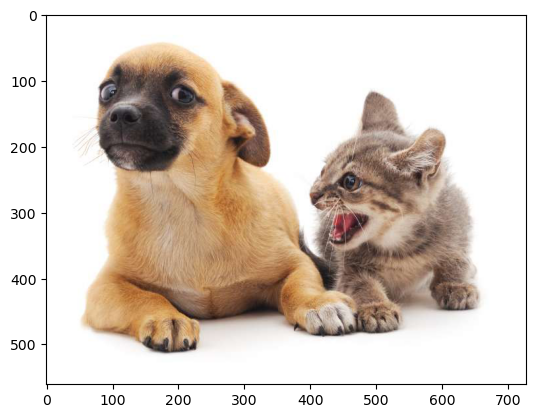

In [3]:
img = plt.imread('img/catdog.jpg')
print("img.shape：",img.shape) # 高561，宽72，3通道
h, w = img.shape[:2]
print(h,w)
X = torch.rand(size=(1,3,h,w)) # 批量大小为1,3通道
Y = multibox_prior(X, sizes=[0.75,0.5,0.25], ratios=[1,2,0.5]) # 占图片sizes尺寸的大小、高宽比ratios尺寸大小的锚框
print(Y.shape) # 1 是批量大小，2042040是一张图片生成的锚框数量，4个元素时每个锚框对应的位置
plt.imshow(img)
plt.show()

In [4]:
boxes = Y.reshape(h,w,5,4)  # 上面的sizes×sizes=3×3，3+3-1=5，故每个像素为中心生成五个锚框    
boxes[250,250,0,:] # 以250×250为中心的第一个锚框的坐标

tensor([0.06, 0.07, 0.63, 0.82])

In [5]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    def _make_list(obj, default_values=None):
        # 如果obj为None，使用默认值；如果obj不是列表或元组，将其转换为列表
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    
    # 处理labels，确保其为列表形式
    labels = _make_list(labels) 
    # 处理colors，确保其为列表形式
    colors = _make_list(colors, ['b','g','r','m','c']) 
    # 遍历所有边界框
    for i, bbox in enumerate(bboxes): 
        # 选择颜色
        color = colors[i % len(colors)] 
        # 使用边界框和颜色生成矩形框
        rect = my_d2l.bbox_to_rect(bbox.detach().numpy(),color) 
        # 在图像上添加矩形框
        axes.add_patch(rect) 
        # 如果存在标签
        if labels and len(labels) > i: 
            # 根据边界框的颜色选择标签的颜色
            text_color = 'k' if color == 'w' else 'w' 
            # 在边界框上添加标签
            axes.text(rect.xy[0], rect.xy[1], labels[i], va='center',
                     ha='center', fontsize=9, color=text_color,
                     bbox=dict(facecolor=color, lw=0))

fig.axes： Axes(0.125,0.11;0.775x0.77)
boxes[250,250,:,:]：
 tensor([[ 0.06,  0.07,  0.63,  0.82],
        [ 0.15,  0.20,  0.54,  0.70],
        [ 0.25,  0.32,  0.44,  0.57],
        [-0.06,  0.18,  0.75,  0.71],
        [ 0.14, -0.08,  0.55,  0.98]])
bbox_scale： tensor([728, 561, 728, 561])
boxes[250,250,:,:] * bbox_scale：
 tensor([[ 40.13,  40.12, 460.88, 460.87],
        [110.25, 110.25, 390.75, 390.75],
        [180.38, 180.38, 320.62, 320.62],
        [-47.02, 101.74, 548.02, 399.26],
        [101.74, -47.02, 399.26, 548.02]])


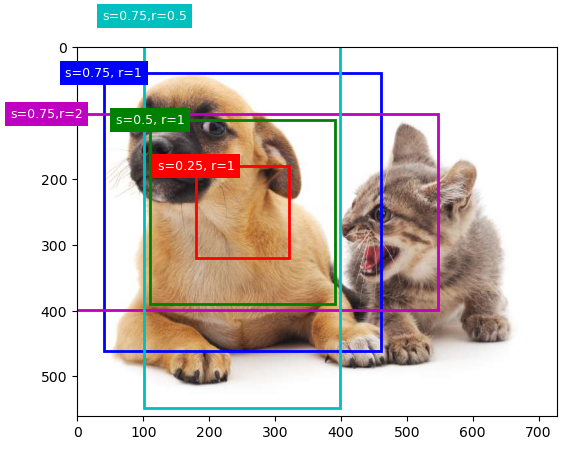

In [6]:
bbox_scale = torch.tensor((w,h,w,h)) 
fig = plt.imshow(img) 
print("fig.axes：",fig.axes)
print("boxes[250,250,:,:]：\n",boxes[250,250,:,:])
print("bbox_scale：", bbox_scale)
print("boxes[250,250,:,:] * bbox_scale：\n",boxes[250,250,:,:] * bbox_scale)
# 画出以250×250像素为中心的不同高宽比的五个锚框
show_bboxes(fig.axes, boxes[250,250,:,:] * bbox_scale, ['s=0.75, r=1','s=0.5, r=1','s=0.25, r=1','s=0.75,r=2','s=0.75,r=0.5']) 
plt.show()

In [7]:
def box_iou(boxes1,boxes2):
    """计算两个锚框或边界框列表中成对的交并比"""
    # 定义一个lambda函数，计算一个锚框或边界框的面积
    box_area = lambda boxes: ((boxes[:,2] - boxes[:,0]) *
                             (boxes[:,3] - boxes[:,1]))
    # 计算boxes1中每个框的面积
    areas1 = box_area(boxes1) 
    # 计算boxes2中每个框的面积
    areas2 = box_area(boxes2) 
    # 计算交集区域的左上角坐标（对于每对框，取其左上角坐标的最大值）
    inter_upperlefts = torch.max(boxes1[:,None,:2],boxes2[:,:2]) 
    # 计算交集区域的右下角坐标（对于每对框，取其右下角坐标的最小值）
    inter_lowerrights = torch.min(boxes1[:,None,2:],boxes2[:,2:])
    # 计算交集区域的宽和高（如果交集不存在，宽和高为0）
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # 两两矩形相交部分的面积
    inter_areas = inters[:,:,0] * inters[:,:,1]
    # 计算并集区域的面积（boxes1的面积 + boxes2的面积 - 交集的面积）
    union_areas = areas1[:,None] + areas2 - inter_areas 
    # 返回交并比（交集的面积除以并集的面积）
    return inter_areas / union_areas

In [8]:
def assign_anchor_to_bbox(ground_truth,anchors,device,iou_threshold=0.5):
    """
    边界框 锚框 设备 iou_threshold：如果一个锚框跟任何一个真实边框的IoU都小于这个值就扔掉不要了，作为背景框
    将最接近的真实边界框分配给锚框
    """
    
    # 获取锚框和真实边界框的数量
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0] 
    
    # 计算所有的锚框和真实边缘框的IOU
    jaccard = box_iou(anchors,ground_truth) 
    
    # 创建一个长度为num_anchors的张量，用-1填充，表示锚框到真实边界框的映射（初始时没有分配）
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long, device=device)    
    
    # 对于每个锚框，找到与其IoU最大的真实边界框
    max_ious, indices = torch.max(jaccard, dim=1)
    
    # 找到IoU大于等于阈值（如0.5）的锚框，将这些锚框分配给对应的真实边界框
    anc_i = torch.nonzero(max_ious >= 0.5).reshape(-1)
    box_j = indices[max_ious >= 0.5]
    anchors_bbox_map[anc_i] = box_j
    
    # 初始化用于删除行和列的张量
    col_discard = torch.full((num_anchors,),-1)
    row_discard = torch.full((num_gt_boxes,),-1)
    
    # 通过迭代找到IoU最大的锚框，并将其分配给对应的真实边界框
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard) # 找IOU最大的锚框
        box_idx = (max_idx % num_gt_boxes).long() # 通过取余数操作，得到该元素对应的真实边界框的索引
        anc_idx = (max_idx / num_gt_boxes).long() # 通过整除操作，得到该元素对应的锚框的索引
        
        # 更新锚框到真实边界框的映射
        anchors_bbox_map[anc_idx] = box_idx
        
        # 在jaccard矩阵中删除已分配的锚框所在的行和列，以避免重复分配
        jaccard[:,box_idx] = col_discard # 把最大Iou对应的锚框在 锚框-类别 矩阵中的一列删掉
        jaccard[anc_idx,:] = row_discard # 把最大Iou对应的锚框在 锚框-类别 矩阵中的一行删掉
    
    #函数返回一个张量anchors_bbox_map，它的长度与锚框的数量相同。
    #这个张量用于存储每个锚框分配到的真实边界框的索引。
    #如果某个锚框没有分配到真实边界框，那么在这个张量中对应的位置就会是-1。
    #如果某个锚框分配到了真实边界框，那么在这个张量中对应的位置就会是分配到的真实边界框的索引。  
    #例如，如果我们有5个锚框和3个真实边界框，那么anchors_bbox_map可能会是这样的：[0, -1, 1, 2, -1]。这表示第1个锚框被分配到了第1个真实边界框，第2个锚框没有被分配到真实边界框，第3个锚框被分配到了第2个真实边界框，第4个锚框被分配到了第3个真实边界框，第5个锚框没有被分配到真实边界框。
    return anchors_bbox_map

In [9]:
def offset_boxes(anchors,assigned_bb,eps=1e-6):
    """对锚框偏移量的转换"""
    # 将锚框从(左上角, 右下角)的形式转换为(中心点, 宽度, 高度)的形式
    c_anc = d2l.box_corner_to_center(anchors) 
    # 将被分配的真实边界框从(左上角, 右下角)的形式转换为(中心点, 宽度, 高度)的形式
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb) 
    # 计算中心点的偏移量，并进行缩放
    offset_xy = 10 * (c_assigned_bb[:,:2] - c_anc[:,:2] / c_anc[:,2:]) 
    # 计算宽度和高度的偏移量，并进行缩放
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:,2:] / c_anc[:,2:]) 
    # 将中心点和宽高的偏移量合并在一起
    offset = torch.cat([offset_xy, offset_wh], axis=1) 
    # 返回计算得到的偏移量
    return offset 

In [10]:
def multibox_target(anchors, labels):
    """使用真实边界框标记锚框"""
    # 获取批量大小和锚框
    batch_size, anchors = labels.shape[0], anchors.squeeze(0) 
    # 初始化偏移量、掩码和类别标签列表
    batch_offset, batch_mask, batch_class_labels = [], [], [] 
    # 获取设备和锚框数量
    device, num_anchors = anchors.device, anchors.shape[0] 
    # 对于每个样本
    for i in range(batch_size): 
        # 获取该样本的标签
        label = labels[i,:,:] 
        # 将最接近的真实边界框分配给锚框  
        anchors_bbox_map = assign_anchor_to_bbox(label[:,1:],anchors,device) 
        # 生成锚框掩码，用于标记哪些锚框包含目标   
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1,4) 
        # 初始化类别标签 
        class_labels = torch.zeros(num_anchors, dtype=torch.long,device=device) 
        # 初始化被分配的边界框  
        assigned_bb = torch.zeros((num_anchors,4), dtype=torch.float32,device=device) 
        # 获取包含目标的锚框的索引
        indices_true =torch.nonzero(anchors_bbox_map >= 0) 
        # 获取对应的真实边界框的索引
        bb_idx = anchors_bbox_map[indices_true] 
        # 设置包含目标的锚框的类别标签
        class_labels[indices_true] = label[bb_idx,0].long() + 1 
        # 设置被分配的边界框
        assigned_bb[indices_true] = label[bb_idx, 1:] 
        # 计算锚框的偏移量，并通过掩码进行过滤
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask 
        # 将偏移量添加到列表中
        batch_offset.append(offset.reshape(-1)) 
        # 将掩码添加到列表中
        batch_mask.append(bbox_mask.reshape(-1)) 
        # 将类别标签添加到列表中
        batch_class_labels.append(class_labels) 
    # 将所有偏移量堆叠在一起
    bbox_offset = torch.stack(batch_offset) 
    # 将所有掩码堆叠在一起
    bbox_mask = torch.stack(batch_mask) 
    # 将所有类别标签堆叠在一起
    class_labels = torch.stack(batch_class_labels) 
    # 返回每一个锚框到真实标注框的offset偏移
    # bbox_mask为0表示背景锚框，就不用了，为1表示对应真实的物体
    # class_labels为锚框对应类的编号
    # 返回偏移量、掩码和类别标签
    return (bbox_offset, bbox_mask, class_labels) 